In [1]:
import torch
import time
import matplotlib.pyplot as plt


In [2]:
torch.set_default_dtype(torch.float64)

# Data

In [3]:
def data_generator(d, n, r):
    C = torch.rand([r for _ in range(d)])

    U = []

    # Generate orthonormal basis matrices
    for i in range(d):
        U_i, R_i = torch.linalg.qr(torch.rand(n, r), mode='reduced')
        U.append(U_i)
        C = torch.tensordot(C, R_i, dims=([i],[1]))
        C = C.movedim(-1,i)

    A = C.clone()
    for i in range(d):
        A = torch.tensordot(A, U[i], dims=([i],[1]))
        A = A.movedim(-1,i)

    return C,U,A


# Sampling

In [4]:
def sample(tensor_shape, samp_perc): # CHECKED
    # Compute total number of elements in the tensor
    total_elements = torch.prod(torch.tensor(tensor_shape)).item()
    
    num_samples = int(samp_perc * total_elements)

    # Sample indices uniformly from the flattened tensor
    flat_indices = torch.unique(torch.randint(0, total_elements, (num_samples,)))
    while len(flat_indices) < num_samples:
        # If there are duplicate indices, sample more indices
        add_num_samples = num_samples - len(flat_indices)
        additional_indices = torch.unique(torch.randint(0, total_elements, (add_num_samples,)))
        flat_indices = torch.unique(torch.cat((flat_indices, additional_indices)))

    # Convert flat indices to multi-dimensional indices
    indices = torch.unravel_index(flat_indices, tensor_shape)
    indices = torch.stack(indices, dim=1)  # Shape: (num_samples, len(tensor_shape))
    return  indices 

In [5]:
def POmega(T, indices): #CHECKED
    # Create an output tensor of the same shape, initialized with zeros
    output_tensor = torch.zeros_like(T)
    
    # Split indices into a tuple for advanced indexing
    split_indices = tuple(indices[:, i] for i in range(indices.shape[1]))
    
    # Use the sampled indices to place elements in the output tensor
    output_tensor[split_indices] = T[split_indices]
    
    return output_tensor

In [6]:
def PTxM(C_X,U_X,E):
    d = len(E.shape)
    I = E.shape

    # G part
    G = E.clone()
    for j in range(d):
        G = torch.tensordot(G, U_X[j].T, dims=([j],[1]))
        G = G.movedim(-1,j)

    proj = G.clone()
    for i in range(d):
        proj = torch.tensordot(proj, U_X[i], dims=([i],[1]))
        proj = proj.movedim(-1,i)

    # V part
    V = []
    for i in range(d):
        temp = E.clone()
        C_i = C_X.movedim(i, 0).reshape(C_X.shape[i],-1)

        for j in range(d):
            if j!=i:
                temp = torch.tensordot(temp, U_X[j].T, dims=([j],[1]))
                temp = temp.movedim(-1,j)
        temp_i = temp.movedim(i,0).reshape(I[i],-1)

        P_Ui_orth = torch.eye(I[i])-U_X[i]@U_X[i].T
        C_i_inv = C_i.T@((C_i@C_i.T).inverse())
        V_i = P_Ui_orth@temp_i@ C_i_inv

        V.append(V_i)

    for i in range(d):
        proj_i = C_X.clone()
        for j in range(d):
            if j!=i:
                proj_i = torch.tensordot(proj_i, U_X[j], dims=([j],[1]))
                proj_i = proj_i.movedim(-1,j)
            else:
                proj_i = torch.tensordot(proj_i, V[i], dims=([j],[1]))
                proj_i = proj_i.movedim(-1,i)
        proj = proj + proj_i
        
    return G,V, proj

In [7]:
def Rgrad(C_X,U_X,X_Omega,data_Omega):
    E = X_Omega- data_Omega
    grad_G,grad_V,rgrad = PTxM(C_X,U_X,E)
    return grad_G,grad_V,rgrad

In [8]:
def HOSVD(X,r):
    
    ##1. Initialize the factor matrices and the core tensor
    d = len(X.shape)
    U = []

    ##2. reshape the tensor X to mode n unfolding and perform SVD
    for i in range(d):
        X_i = torch.moveaxis(X, i, 0).reshape(X.shape[i],-1)
        # perform the SVD for the mode i unfolding
        [u,_,_] = torch.linalg.svd(X_i,full_matrices=False)
        # factor matrix as the leading r columns of u
        U.append(u[:, :r[i]])

    C = X.clone()
    for i in range(d):
        C = torch.tensordot(C, U[i].T, dims=([i],[1]))
        C = C.movedim(-1,i)

    return [C,U]

In [9]:
def Retract(C_X,U_X,G_eta,V_eta,alpha):
    d = len(U_X) 
    r = C_X.shape

    Q = []
    R = []
    for i in range(d):
        Q_i,R_i = torch.linalg.qr(torch.cat((U_X[i],V_eta[i]),dim = 1), mode='reduced')
        Q.append(Q_i)
        R.append(R_i)
    
    Sshape = [2*k for k in r]
    S = torch.zeros(Sshape)

    main_idx = tuple(slice(0, r[i]) for i in range(d))   
    S[main_idx] = C_X +alpha*G_eta
    for i in range(d):
        idx = tuple(slice(r[i], 2*r[i]) if j == i else slice(0, r[j]) for j in range(d))
        S[idx] = alpha * C_X 

    for i in range(d):
        S = torch.tensordot(S, R[i], dims=([i],[1]))
        S = S.movedim(-1,i)

    [C_S , U_S] = HOSVD(S, r)

    for i in range(d):
        Q[i] = Q[i]@U_S[i]

    X_new = C_S.clone()
    for i in range(d):
        X_new = torch.tensordot(X_new, Q[i], dims=([i],[1]))
        X_new = X_new.movedim(-1,i)

    
    return C_S, Q, X_new
    

In [10]:
def f(X,A,Omega):
    temp = POmega(X - A, Omega).reshape(-1)
    return torch.dot(temp,temp)/2

In [11]:
def RCG(A,C_X_0,U_X_0,X_0,Omega,Omega_test,max_iter=300,tol=1e-6):
    AOmega = POmega(A,Omega)


    ## Riemannian Conjugate Gradient
    X_k = X_0.clone()
    C_X_k = C_X_0.clone()
    U_X_k = U_X_0.copy()

    star_time = time.time()
    X_k_Omega = POmega(X_k,Omega)
    xi_k_G,xi_k_V,xi_k = Rgrad(C_X_k,U_X_k,X_k_Omega,AOmega)
    eta_k = -xi_k
    eta_k_G = -xi_k_G
    eta_k_V = [-v for v in xi_k_V]

    print('first Riemannian gradient computed:',time.time()-star_time)

    star_time = time.time()
    # line search
    temp = POmega(eta_k,Omega).reshape(-1)
    a_top = torch.dot(temp,(AOmega-X_k_Omega).reshape(-1))
    a_bot = torch.dot(temp,temp)
    alpha_k = a_top/a_bot
    print('first line search:',time.time()-star_time)


    star_time = time.time()
    # retraction
    C_X_k, U_X_k, X_k= Retract(C_X_k,U_X_k,eta_k_G,eta_k_V,alpha_k)
    xi_km = xi_k
    eta_km = eta_k
    print('first retraction:',time.time()-star_time)


    iter = 1
    
    X_k_Omega = POmega(X_k,Omega)
    
    star_time = time.time()

    err = torch.norm(X_k_Omega-AOmega)/torch.norm(AOmega)

    Err = [torch.norm(POmega(X_k-A,Omega_test))/torch.norm(POmega(A,Omega_test))]

    print('first error:',time.time()-star_time)

    while iter <= max_iter and err > tol:


        star_time = time.time()
        xi_k_G,xi_k_V,xi_k = Rgrad(C_X_k,U_X_k,X_k_Omega,AOmega)
        print('Riemannian gradient computed:',time.time()-star_time)

        star_time = time.time()
        # beta_k
        b_top = torch.dot(xi_k.reshape(-1),(xi_k-PTxM(C_X_k,U_X_k,xi_km)[-1]).reshape(-1))
        b_bot = torch.norm(xi_km)**2
        beta_k = b_top/b_bot
        beta_k = max(0,beta_k)
        print('beta_k:',time.time()-star_time)

        # conjugate gradient
        star_time = time.time()
        conj_G,conj_V,conj = PTxM(C_X_k,U_X_k,eta_km)
        eta_k = - xi_k + beta_k*conj
        eta_k_G = - xi_k_G + beta_k*conj_G
        eta_k_V = [-xi_k_V[i] + beta_k*conj_V[i] for i in range(len(xi_k_V))]
        print('conjugate gradient:',time.time()-star_time)

        # line search
        star_time = time.time()
        temp = POmega(eta_k,Omega).reshape(-1)
        a_top = torch.dot(temp,(AOmega-X_k_Omega).reshape(-1))
        a_bot = torch.dot(temp,temp)
        alpha_k = a_top/a_bot
        print('line search:',time.time()-star_time)

        # backtracking line search
        star_time = time.time()
        m = 0
        LHS = f(X_k,A,Omega) - f(Retract(C_X_k,U_X_k,eta_k_G,eta_k_V,(2**-m)*alpha_k)[-1],A,Omega)
        RHS = -1e-4*torch.dot(xi_k.reshape(-1),(2**-m)*alpha_k*eta_k.reshape(-1))
        while LHS < RHS:
            m += 1
            LHS = f(X_k,A,Omega) - f(Retract(C_X_k,U_X_k,eta_k_G,eta_k_V,(2**-m)*alpha_k)[-1],A,Omega)
            RHS = -1e-4*torch.dot(xi_k.reshape(-1),(2**-m)*alpha_k*eta_k.reshape(-1))
            print('LHS:',LHS)
            print('RHS:',RHS)
            if m > 3:
                print('backtracking line search after 5 steps')
                break
        print('backtracking line search:',time.time()-star_time)

        
        star_time = time.time()
        C_X_k, U_X_k, X_k= Retract(C_X_k,U_X_k,eta_k_G,eta_k_V,alpha_k)

        xi_km = xi_k
        eta_km = eta_k
        print('retraction:',time.time()-star_time)

        star_time   = time.time()

        X_k_Omega = POmega(X_k,Omega)

        err = torch.norm(X_k_Omega-AOmega)/torch.norm(AOmega)

        err_test = torch.norm(POmega(X_k-A,Omega_test))/torch.norm(POmega(A,Omega_test))

        print('error:',time.time()-star_time)
        Err.append(err_test)
        print(f"Iteration {iter}: Training Error = {err:.6e}, Test Error = {err_test:.6e}")
        iter += 1

    return X_k,Err,iter

In [12]:
# Example usage
d = 3  # Number of modes
n = 100  # Mode size
r = 5  # Multilinear rank
shape = [n for _ in range(d)]

start_time = time.time()
[_,_,A_true] = data_generator(d, n, r)
print("kron time: ", time.time()-start_time)

kron time:  0.005300998687744141


In [13]:
samp_perc = 0.05
Omega = sample(shape, samp_perc)
Omega_test = sample(shape, samp_perc)
[C_init,U_init,X_init] = data_generator(d,n,r)
star_time = time.time()
A_hat_005,Err_test_005,iter_005 = RCG(A_true,C_init,U_init,X_init,Omega,Omega_test,tol=1e-12)
end_time = time.time()
time_005 = end_time - star_time

samp_perc = 0.1
Omega = sample(shape, samp_perc)
Omega_test = sample(shape, samp_perc)
[C_init,U_init,X_init] = data_generator(d,n,r)
star_time = time.time()
A_hat_01,Err_test_01,iter_01 = RCG(A_true,C_init,U_init,X_init,Omega,Omega_test,tol=1e-12)
end_time = time.time()
time_01 = end_time - star_time

samp_perc = 0.3
Omega = sample(shape, samp_perc)
Omega_test = sample(shape, samp_perc)
[C_init,U_init,X_init] = data_generator(d,n,r)
star_time = time.time()
A_hat_03,Err_test_03,iter_03 = RCG(A_true,C_init,U_init,X_init,Omega,Omega_test,tol=1e-12)
end_time = time.time()
time_03 = end_time - star_time

samp_perc = 0.5
Omega = sample(shape, samp_perc)
Omega_test = sample(shape, samp_perc)
[C_init,U_init,X_init] = data_generator(d,n,r)
star_time = time.time()
A_hat_05,Err_test_05,iter_05 = RCG(A_true,C_init,U_init,X_init,Omega,Omega_test,tol=1e-12)
end_time = time.time()
time_05 = end_time - star_time

first Riemannian gradient computed: 0.01814866065979004
first line search: 0.0033211708068847656
first retraction: 0.0018768310546875
first error: 0.0051860809326171875
Riemannian gradient computed: 0.014328241348266602
beta_k: 0.014993906021118164
conjugate gradient: 0.011399984359741211
line search: 0.0018939971923828125
backtracking line search: 0.008008956909179688
retraction: 0.0015192031860351562
error: 0.007696866989135742
Iteration 1: Training Error = 6.238424e-02, Test Error = 6.440462e-02
Riemannian gradient computed: 0.011862039566040039
beta_k: 0.01250004768371582
conjugate gradient: 0.013463020324707031
line search: 0.002090930938720703
backtracking line search: 0.005248069763183594
retraction: 0.0019419193267822266
error: 0.005686759948730469
Iteration 2: Training Error = 2.531246e-02, Test Error = 2.677235e-02
Riemannian gradient computed: 0.015442132949829102
beta_k: 0.012458086013793945
conjugate gradient: 0.012757062911987305
line search: 0.0018122196197509766
backtra

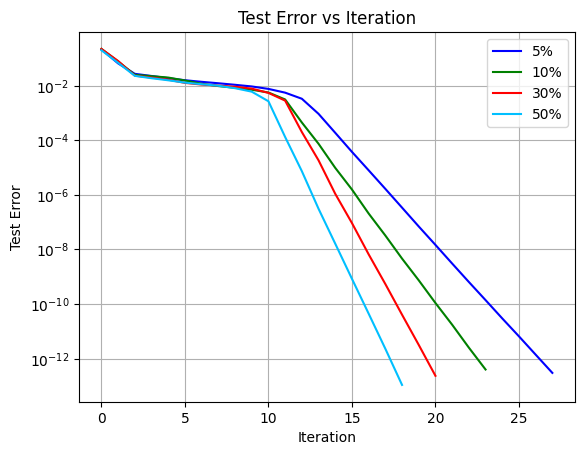

In [14]:
plt.semilogy(Err_test_005,label='5%',color = 'b')
plt.semilogy(Err_test_01,label='10%',color='g')
plt.semilogy(Err_test_03,label='30%',color='r')
plt.semilogy(Err_test_05,label='50%',color='deepskyblue')
plt.xlabel('Iteration')
plt.ylabel('Test Error')
plt.title('Test Error vs Iteration')
plt.grid(True)
plt.legend()
plt.show()


In [15]:
print(f"Time for  5% sampling: {time_005:.2f} seconds")
print(f"Time for 10% sampling: {time_01:.2f} seconds")
print(f"Time for 30% sampling: {time_03:.2f} seconds")
print(f"Time for 50% sampling: {time_05:.2f} seconds")

print(f"Iterations for  5% sampling: {iter_005}")
print(f"Iterations for 10% sampling: {iter_01}")
print(f"Iterations for 30% sampling: {iter_03}")
print(f"Iterations for 50% sampling: {iter_05}")

print(f"Average time per iteration for  5% sampling: {time_005/iter_005:.2f} seconds")
print(f"Average time per iteration for 10% sampling: {time_01/iter_01:.2f} seconds")
print(f"Average time per iteration for 30% sampling: {time_03/iter_03:.2f} seconds")
print(f"Average time per iteration for 50% sampling: {time_05/iter_05:.2f} seconds")

Time for  5% sampling: 1.69 seconds
Time for 10% sampling: 1.35 seconds
Time for 30% sampling: 1.14 seconds
Time for 50% sampling: 1.12 seconds
Iterations for  5% sampling: 28
Iterations for 10% sampling: 24
Iterations for 30% sampling: 21
Iterations for 50% sampling: 19
Average time per iteration for  5% sampling: 0.06 seconds
Average time per iteration for 10% sampling: 0.06 seconds
Average time per iteration for 30% sampling: 0.05 seconds
Average time per iteration for 50% sampling: 0.06 seconds
